# Blunderfist
## Deep Q Network

### Table of contents: <a id='top'></a>

1. [Introduction](#Introduction)
2. [Pseudocode](#pseudocode)
3. [Project Overview](#proj)
    - [Experiment Details](#expdetails)
    - [Neural Network Details](#nndetails)
4. [Code](#code)
    - [Grid World](#gw)
    - [Agent](#agent)
    - [Neural Network](#nn)
    - [Helper Functions](#helper)
    - [Main](#main)
5. [Results](#results)
    - [Output](#output)
    - [Solution](#solution)
    - [MSE](#mse)
    - [Select Q Values](#selectapprox)
    - [Weights Trajectory](#selectweights)
    - [Rewards over episodes](#rewards)
    - [Notes](#notes)
6. [Conclusion](#conclusion)


## Introduction

[Top](#top)

This project uses deep Q learning to learn values for a grid world. Deep Q learning utilizes a neural network to approximate the value function for the agent. This is in contrast to learning a Q table. In continuous state spaces learning a Q table is impossible, therefore replacing it with a function approximator is a good alternative.

Deep Q learning makes use of two neural networks. The first is used to make predictions (the forward pass) that will be used as the ground truth for training the second (forward and backward propagation with weight updates). After a set number of training episodes the weights are updated between the networks in order to keep the target stable. 

A technique known as experience replay is also involved. Experience replay can be summarized as creating a dataset from the agent's experience and then training the network from samples of that experience. This has several benefits, including reducing problems due to correlations between states. The implementation of experience replay involves having the agent choose an action using the $\epsilon$-greedy policy from the current state, receive a reward and the next state, and entering this information into stored memory. In this implementation the experience is stored as a tuple in the form (state, action, reward, new state).

**Objective Function:**

The loss (objective) function for this type of learning problem is given as:

$$ L = \mathbb{E} [ (r + \gamma max_{a'} Q(s',a') - Q(s,a))^2] $$

### Pseudo code for deep Q learning <a id='pseudocode'></a>

[Top](#top)

Initialize the exerience replay memory $D$ to capacity $N$

Initialize the action-value funciton $Q$ with random weights $\theta$

Initialize the target action-value funciton $\hat{Q}$ with weights $\theta^{-} = \theta$

For episodes m = 1 to $M$:
- Initialize sequence $s_1 = $ {$x_1$} and preprocessed sequence $\phi_1 = $ {$\phi_1$}
- For t = 1 to $T$:
 - Using $\epsilon$-greedy either select action a random action $a_t$, otherwise $a_t = argmax_a Q(\phi(s_t), a;\theta)$
 - Execute action $a_t$ and observe reward $r_t$ and state $s'$
 - Store transition $(\phi_t, a_t, r_t, \phi_{t+1})$ in $D$
 - Sample a random mini-batch of transitions $(\phi_j, a_j, r_j, \phi_{j+1})$ from $D$
 - Set $y_j$
     - if episode terminates at step j + 1 $y_j = r_j$
     - otherwise $y_j = r_j + \gamma max_{a'} \hat{Q} (\phi_{j+1}, a'; \theta^{-})$
 - Perform a gradient descent step on $(y_j - Q(\phi_j, a_j; \theta))^2$ wrt network parameters $\theta$
 - Every C steps reset $\hat{Q} = Q$
- End

End

### Project Overview <a id='proj'></a>

**Outline of experiment details:** <a id='expdetails'></a>

[Top](#top)

- Agent receives -1 points for each step
- Agent stays in place if attempting to move off of the grid
- Goal state is worth 100 points
- Walls are rewarded with -100 points
- $\gamma = 0.95$ in order to encourage agent to maximize future rewards
- $\epsilon$ is decayed as training progresses. It begins at $\epsilon = 0.5$ (50% of the time random action selection) and decays until it reaches $\approx 0.1$

**Overview of the neural networks:** <a id='nndetails'></a>

[Top](#top)

- Each network consists of an input layer, hidden layer, and output layer
- Input layer is the flattened state space
- Hidden layer has 128 nodes and a sigmoid activation function
- Output layer has 4 nodes (1 per action available, North, South, East, West) and no activation function (linear)
- Each network shares the same initial weights
- Network weights are updated between networks every 50 time steps
- Learning rate is set at 0.007

In [19]:
import numpy as np
import copy
import time
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.animation as animation

<a id='code'></a>

### Environment, Gridworld, and Gridworld class  <a id='gw'></a>

[Top](#top)

In [20]:
class Environment():
    def __init__(self
                , world # world previously created
                , start # location agent will start ex: (0,0)
                , goal # agent goal location ex: (m-1, n-1)
                , walls # any obstacles in the world
                , rewards # rewards for each state
                , actions  # actions, list of numbers ex: 4 actions = list(range(1,5)) [1,2,3,4] to correspond to N,S,E,W moves
                ):
        """class to keep environment information in one place"""
        
        self.world = world
        self.h = world.shape[0]
        self.w = world.shape[1]
        self.start = start
        self.goal = goal
        self.states = np.array(np.meshgrid(list(range(self.h)), list(range(self.w)))).T.reshape(-1,2)
        self.walls = walls
        self.rewards = rewards 
        self.actions = actions
        self.num_actions = len(self.actions)
        
    def environment_dict(self):
        """returns dict of environment values"""
        
        self.env_dict = {
            'world': self.world,
            'shape': (self.h, self.w),
            'start': self.start,
            'goal': self.goal,
            'states': self.states,
            'walls': self.walls,
            'rewards': self.rewards,
            'actions': self.actions,
            'num_actions': self.num_actions
        }
        
        return self.env_dict

In [21]:
def print_world(world):
    
    w = np.zeros_like(world, dtype = 'U6')
    for i in range(world.shape[0]):
        for j in range(world.shape[1]):
            if world[i,j] == 0.0:
                w[i,j] = '0'
            else:
                w[i,j] = 'X'
    print(f"World\n{w}")

In [22]:
def make_random_maze_world(m,n, start, goal, move_reward, obstacle_reward, goal_reward):
    
    np.random.seed(2)
    world = np.zeros((m,n))

    for i in range(world.shape[0]):
        for j in range(world.shape[1]):
            if np.random.rand() < 0.25:
                world[i,j] = -100

    world[:2][:,:2] = 0 # create a space to begin in case wall was placed there
    world[m-2:][:,m-2:] = 0 # create a space to end in case wall was placed there
#     print(world)
#     print_world(world)
    walls = {}
    for i in range(world.shape[0]):
        for j in range(world.shape[1]):
            walls[(i,j)] = world[i,j]
    rewards = {k:(move_reward if v == 0.0 else v) for k,v in walls.items()}
    rewards[goal] = goal_reward
    
    return world, start, goal, walls, rewards

In [23]:
class GridWorld():
    def __init__(self, m, n, world, goal, walls, rewards):
        """initial params for class"""
        
        self.m = m
        self.n = n
        self.world = world
        self.walls = walls
        self.rewards = rewards
        self.goal = [k for k,v in walls.items() if v != 0]
        self.term = goal

    def terminal(self, state):
        """returns true if goal, false otherwise"""

        return state in self.goal


    def isLegal(self, state):
        """determines if action is legal
        illegal action = moving off gridworld"""
        
        if state[0] < 0 or state[0] > self.m-1:
            return False
        elif state[1] < 0 or state[1] > self.n-1:
            return False
        return True
    
    def actions(self, state):
        """given a state, checks for goal state then legal actions, returns list of actions
        illegal actions have _ appended and will return same value as current state when sent
        thru sp_prob_reward() below"""
        
        result = []
        # n,s,e,w = 0,1,2,3
        moves = {0:[-1,0],1:[1,0],2:[0,1],3:[0,-1]}

        for k,v in moves.items():
            if not self.isLegal(state + np.array(v)):
                # stay in same location
                result.append(f"{k}_")

            elif not self.term == state:
                result.append(k)

        return result

    def sp_reward(self, state, action):
        """given state and action returns s' and reward for that action"""

        result = []
        moves = np.array([[-1,0],[1,0],[0,1],[0,-1]])     
         
        if action == 0:
            s_prime = state + moves[0]
        elif action == 1:
            s_prime = state + moves[1]
        elif action == 2:
            s_prime = state + moves[2]
        elif action == 3:
            s_prime = state + moves[3]
        else:
            s_prime = state
        s_prime = tuple(s_prime)
        
        return s_prime, self.rewards[s_prime]


### Agent <a id='agent'></a>

[Top](#top)

In [24]:
class DQAgent():
    def __init__(self, 
                 epsilon, # exploration rate
                 gamma, # discount
                 env): # the environment 

        self.e = epsilon # epsilon, prob of exploring
        self.g = gamma
        self.R = env['rewards']
        self.start = env['start']
        self.goal = env['goal']
        self.buffer = []
        self.actions = env['actions']
        self.rewards = 0

        
    def choose_max(self, actions):
        """selects randomly from list of max values if more than one
        params:
            actions: values of avaible actions in given state
        returns:
            val, (int) randomly selected index of highest q_value"""

        tmp_q_values = np.array([x for x in actions])
        
        max_lst = np.squeeze(np.where(tmp_q_values == max(tmp_q_values)))
        # randomly select index from max values
        if max_lst.size > 1:
            val = np.random.choice(max_lst)
        elif max_lst == 0:
            val = 0
        else:
            val = max_lst

        return val


    def add_to_buff(self, latest):
        """adds to experience replay buffer"""

        if len(self.buffer) == 500:
            del self.buffer[0]
        self.buffer.append(latest)


    def action_selection(self, q_vals):
        """selects agent action selection"""

        q_vals = np.squeeze(q_vals)

        if np.random.random() < self.e: # explore
            action = np.random.default_rng().choice(self.actions)
        else: # greedy
            action = self.choose_max(list(q_vals))

        return action        

        
    def step(self, gw, action):
        """takes a step to another state
        updates Q value for state
        updates current state to s'
        params:
        gw: gridworld instance (needs s', prob, reward)
        action: action selected
        a_select: index of action selected
        """

        # current state
        state = self.state
        
        # get the action from gridworld
        gw_actions = gw.actions(state)
        
        # state entered and reward gained by taking action
        s_prime, r = gw.sp_reward(state, gw_actions[action])      

        # create tuple and add to buffer
        tup = (state, action, r, s_prime)
        self.add_to_buff(tup)

        # update state to s'
        self.state = s_prime
        # update rewards
        self.rewards += r


### Neural Network for Deep Q Learning <a id='nn'></a>

[Top](#top)

In [25]:
class NN():
    def __init__(self,
                 inputs,
                 layers,
                 nodes,
                 activation,
                 classes,
                 lr,
                 batch_size
                ):

        self.layers = layers
        self.nodes = (inputs, *nodes, classes)
        self.values = {}
        self.activation = activation
        self.outputs = classes
        self.lr = lr
        self.mse = []
        self.selected_weights = []
        self.epochs = 1
        self.batch_size = batch_size

    def init_weights(self):
        """creates array of weights for each layer stored in dict"""

        self.W = {}
        self.b = {}
        for l in range(1, self.layers):
            self.W[l] = np.random.random((self.nodes[l-1], self.nodes[l]))
            self.b[l] = np.random.random((1, self.nodes[l]))
            self.values[l] = {'linears':0,'activations':0}
            self.values[l]['linears'] = np.zeros((1, self.nodes[l]))
            self.values[l]['activations'] = np.zeros((1, self.nodes[l]))

    
    def format_input(self, w, s):
        """ flattens state to be input to NN
        w: env['world']
        s: state from buffer"""

        world = np.zeros(w.shape)
        world[s] = 1
        
        return world.reshape(1,-1) # flattened into vector
    
    def activate(self, Z):
        """activation function"""
        if self.activation == 'sigmoid':
            return (1 / (1 + np.exp(-Z)))
        elif self.activation == 'relu':
            return np.maximum(0, Z)


    def d_activate(self, x):
        """derivative of sigmoid"""
        if self.activation == 'sigmoid':
            return x * (1 - x)
        elif self.activation == 'relu':
            return 1. * (x > 0)


    def forward(self, inputs):
        """forward pass"""
        
        l1_Z = np.dot(inputs, self.W[1]) + self.b[1]
        self.values[1]['linears'] = l1_Z
        l1_A = self.activate(l1_Z)
        self.values[1]['activations'] = l1_A
        l2 = np.dot(l1_A, self.W[2]) + self.b[2]
        self.values[2]['activations'] = l2


    def backward(self, X, Y, a):
        """back propogation
        X: input to network, formatted 1d vector (flattened gridworld)
        Y: target output
        a: action taken during episode
        returns: None, updates weights"""

        td_err = (self.values[2]['activations']- Y)
        mse = np.sum(np.square(td_err)) / (2 * self.batch_size)
        self.mse.append(mse)
        selected_w = self.W[2][0:5]
        self.selected_weights.append(copy.deepcopy(selected_w))
        dQ_pred = np.zeros_like(td_err)

        # create 1 hot encoded matrix for weight updates
        for i in range(dQ_pred.shape[0]):
            for j in range(dQ_pred.shape[1]):
                dQ_pred[i][a[i]] = 1

        dQ_pred *= td_err
        dW2 = np.dot(self.values[1]['activations'].T, dQ_pred) # only update weights used
        db2 = np.sum(dQ_pred, axis = 0, keepdims = True)
        
        d_layer_1_A = np.dot(dQ_pred, self.W[2].T) # d of layer1 activations
        d_layer_1_Z = d_layer_1_A * self.d_activate(self.values[1]['activations'])
        dW1 = np.dot(X.T, d_layer_1_Z)
        db1 = np.sum(d_layer_1_Z, axis = 0, keepdims = True)

        self.W[2] += -self.lr * dW2 / self.batch_size
        self.b[2] += -self.lr * db2 / self.batch_size
        self.W[1] += -self.lr * dW1 / self.batch_size
        self.b[1] += -self.lr * db1 / self.batch_size

        
    def train(self, X, Y, a, epochs):
        """trains network"""

        if epochs is None:
            epochs = self.epochs
            
        for e in range(epochs):
            self.forward(X)
            self.backward(X, Y, a)


    def compute_y(self, sample, agent, env, gw):
        """get target value"""
        
        state, action, r, s_prime = sample

        if  gw.terminal(s_prime):
            tgt = r
        else:
            sp = self.format_input(env['world'], s_prime)
            q_val = np.squeeze(self.inference(sp))
            tgt = r + (agent.g * max(q_val))
            
        return tgt


    def inference(self, x_test):
        """inference forward"""

        l1_Z = np.dot(x_test, self.W[1]) + self.b[1]
        l1_A = self.activate(l1_Z)
        return np.dot(l1_A, self.W[2]) + self.b[2]


### Helper Functions <a id='helper'></a>

[Top](#top)

In [26]:
def plot_gridworld(env, route, solution = False, start = None):
    """plots a route based on the best path determined by the learning method
    params:
        world: gridworld as np array
        route: best route to goal
    returns:
        None: displays gridworld and route as matplot plot 
    """
    
    world = env['world']
    m = world.shape[0]
    n = world.shape[1]
    walls = []
    for i in range(world.shape[0]):
        for j in range(world.shape[1]):
            tmp_w = np.flip(world, axis = 0)
            if np.rot90(tmp_w,3)[i,j] == -100.0:
                walls.append([i,j])

    if start is None:
        start = env['start']
    else:
        start = start

    end = env['goal']

    fig = plt.figure(figsize = (15,15))
    ax = fig.gca()

    # start
    plt.fill([start[1], start[1], start[1]+1, start[1]+1], [start[0], start[0]+1, start[0]+1, start[0]], color = 'yellow', alpha = 0.5)
    plt.annotate('Start', xy =(start[1] + 0.1, start[0] + .5),
                        xytext =(start[1] + 0.1, start[0] + .5))
    # end
#     plt.fill([m-1, m-1, m, m], [m-1, m, m, m-1], color = 'green', alpha = 0.5)
    plt.fill([end[0], end[0], end[0]+1, end[0]+1], [end[0], end[0]+1, end[0]+1, end[0]], color = 'green', alpha = 0.5)
    plt.annotate('End', xy =(end[0]+0.1, end[1]+0.5),
                        xytext =(end[0]+0.1, end[1]+0.5))

    for wall in walls:
        plt.fill([wall[0], wall[0], wall[0]+1, wall[0]+1], [wall[1],wall[1]+1, wall[1]+1, wall[1]], color = 'red', alpha = 0.5)

    ax.set_xticks(np.arange(0, n+1, 1))
    yax = [x for x in range(m+1)[::-1]]
    ax.set_yticks(yax)

    plt.xlim(0, n)
    plt.ylim(m, 0)
    plt.grid()
            
    if solution:
        x = [start[1] + 0.5]
        y = [start[0] + 0.5]

        for i in range(len(route)):
            x.append(route[i][1] + .5)
            y.append(route[i][0] + .5)
        plt.plot(x, y, color = 'green')

    plt.show()

In [27]:
def animate_movements(env, route):

    world = env['world']
    m, n = world.shape

    walls = []
    for i in range(world.shape[0]):
        for j in range(world.shape[1]):
            tmp_w = np.flip(world, axis = 0)
            if np.rot90(tmp_w,3)[i,j] == -100.0:
                walls.append([i,j])

    start = route[0]
    end = env['goal']

    fig = plt.figure(figsize = (10,10))
    ax = fig.gca()

    for wall in walls:
        plt.fill([wall[0], wall[0], wall[0]+1, wall[0]+1], [wall[1],wall[1]+1, wall[1]+1, wall[1]], color = 'red', alpha = 0.5)

    # start
    plt.fill([start[1], start[1], start[1]+1, start[1]+1], [start[0], start[0]+1, start[0]+1, start[0]], color = 'yellow', alpha = 0.5)
    plt.annotate('Start', xy =(start[1] + 0.1, start[0] + .5),
                        xytext =(start[1] + 0.1, start[0] + .5))
    # end
#     plt.fill([m-1, m-1, m, m], [m-1, m, m, m-1], color = 'green', alpha = 0.5)
    plt.fill([end[0], end[0], end[0]+1, end[0]+1], [end[0], end[0]+1, end[0]+1, end[0]], color = 'green', alpha = 0.5)
    plt.annotate('End', xy =(end[0]+0.1, end[1]+0.5),
                        xytext =(end[0]+0.1, end[1]+0.5))
    
    ax.set_xticks(np.arange(0, n+1, 1))
    yax = [x for x in range(m+1)[::-1]]
    ax.set_yticks(yax)
    
    plt.xlim(0, n)
    plt.ylim(m, 0)
    plt.grid()
    x = [start[1] + 0.5]
    y = [start[0] + 0.5]

    for i in range(len(route)):
        x.append(route[i][1] + .5)
        y.append(route[i][0] + .5)

    line, = ax.plot([], [], lw=2)

    def init():
        line.set_data([], [])
        return (line,)

    
    def animate_plot(i):
        line.set_data(x[:i], y[:i])
        return (line,)

    anim = animation.FuncAnimation(
        fig, # has to be fig
        animate_plot, # the function above, i is the interval I think
        init_func = init, # the init function above, sets the lines for the animation
        frames = 100, # the length of the animation, too short and won't finish
        interval = 125, # the speed, higher = slower
        blit = True) # only plots new info each time if True
    
    anim.save(f"route_animation_state{start}.gif")

In [28]:
# def animate_movements(env, route):

#     world = env['world']
#     m, n = world.shape

#     walls = []
#     for i in range(world.shape[0]):
#         for j in range(world.shape[1]):
#             tmp_w = np.flip(world, axis = 0)
#             if np.rot90(tmp_w,3)[i,j] == -100.0:
#                 walls.append([i,j])

#     start = route[0]
#     end = env['goal']

#     fig = plt.figure(figsize = (10,10))
#     ax = fig.gca()

#     for wall in walls:
#         plt.fill([wall[0], wall[0], wall[0]+1, wall[0]+1], [wall[1],wall[1]+1, wall[1]+1, wall[1]], color = 'red', alpha = 0.5)

#     # start
#     plt.fill([start[1], start[1], start[1]+1, start[1]+1], [start[0], start[0]+1, start[0]+1, start[0]], color = 'yellow', alpha = 0.5)
#     plt.annotate('Start', xy =(start[1] + 0.1, start[0] + .5),
#                         xytext =(start[1] + 0.1, start[0] + .5))
#     # end
# #     plt.fill([m-1, m-1, m, m], [m-1, m, m, m-1], color = 'green', alpha = 0.5)
#     plt.fill([end[0], end[0], end[0]+1, end[0]+1], [end[0], end[0]+1, end[0]+1, end[0]], color = 'green', alpha = 0.5)
#     plt.annotate('End', xy =(end[0]+0.1, end[1]+0.5),
#                         xytext =(end[0]+0.1, end[1]+0.5))
    
#     ax.set_xticks(np.arange(0, n+1, 1))
#     yax = [x for x in range(m+1)[::-1]]
#     ax.set_yticks(yax)
    
#     plt.xlim(0, n)
#     plt.ylim(m, 0)
#     plt.grid()
#     x = [start[1] + 0.5]
#     y = [start[0] + 0.5]

#     for i in range(len(route)):
#         x.append(route[i][1] + .5)
#         y.append(route[i][0] + .5)

#     line, = ax.plot([], [], lw=2)

#     def init():
#         line.set_data([], [])
#         return (line,)

    
#     def animate_plot(i):
#         line.set_data(x[:i], y[:i])
#         return (line,)

#     anim = animation.FuncAnimation(
#         fig, # has to be fig
#         animate_plot, # the function above, i is the interval I think
#         init_func = init, # the init function above, sets the lines for the animation
#         frames = 100, # the length of the animation, too short and won't finish
#         interval = 125, # the speed, higher = slower
#         blit = True) # only plots new info each time if True
    
#     anim.save(f"route_animation_state{start}.gif")

In [29]:
def follow_policy(gw, agent, env, q_model, start = None, end = None):
    """follows optimal policy
    params:
        gw: grid world instance
        agent: agent instance
        env: environment dictionary
        q_model: neural network for estimating Q values
    returns:
        route_lst: list of tuples along route, start to finish, for use in plotting route
    """
    
    if start is None:
        state = agent.start
    else:
        state = start
    
    if end is None:
        end_state = env['goal']
    else:
        end_state = end
        
    actions = list(range(4))
    steps = {0:(-1,0), 1:((1,0)), 2:(0,1), 3:(0,-1)}
    directions = {0:'N', 1:'S', 2:'E', 3:'W'}
    route_lst = [state]
    c = 0
    
    print(f"Agent starts in {state}")
    while True:
        if state == end_state:
            print("Solved!")
            break

        if state[0] < 0 or state[0] > gw.m-1 or state[1] < 0 or state[1] > gw.n-1:
            print("Agent fell off gridworld, needs more training")
            break

        options = q_model.inference(q_model.format_input(env['world'], state))
        optimal = np.argmax(options)

        print(f"Agent moved {directions[optimal]}")
        state += np.array(steps[optimal])
        state = tuple(state)
        print(f"Moved to {state}")
        route_lst.append(state)
        
        c += 1
        if c == 100:
            print("fail")
            break
        
    return route_lst

In [30]:
def follow_policy(gw, agent, env, q_model, start = None):
    """follows optimal policy
    params:
        gw: grid world instance
        agent: agent instance
        env: environment dictionary
        q_model: neural network for estimating Q values
    returns:
        route_lst: list of tuples along route, start to finish, for use in plotting route
    """
    
    if start is None:
        state = agent.start
    else:
        state = start

    actions = list(range(4))
    steps = {0:(-1,0), 1:((1,0)), 2:(0,1), 3:(0,-1)}
    directions = {0:'N', 1:'S', 2:'E', 3:'W'}
    route_lst = [state]
    c = 0
    
    print(f"Agent starts in {state}")
    while True:
        if state == env['goal']:
            print("Solved!")
            break

        if state[0] < 0 or state[0] > gw.m-1 or state[1] < 0 or state[1] > gw.n-1:
            print("Agent fell off gridworld, needs more training")
            break

        options = q_model.inference(q_model.format_input(env['world'], state))
        optimal = np.argmax(options)

        print(f"Agent moved {directions[optimal]}")
        state += np.array(steps[optimal])
        state = tuple(state)
        print(f"Moved to {state}")
        route_lst.append(state)
        
        c += 1
        if c == 100:
            print("fail")
            break
        
    return route_lst

In [31]:
def plot_mse(mse, e):
    """plots MSE from each iteration
    params:
        mse: list of MSE values
    returns:
        None, displays plot"""
    
    plt.plot(mse, label = 'MSE')
    plt.title(f"MSE over {e}")
    plt.xlabel(f"{e}")
    plt.ylabel("MSE")
    plt.legend()
    plt.show()


In [32]:
def plot_weight_traj(w):
    """plots weight trajectories for selected weights from each iteration
    params:
        w: list of select weight values
    returns:
        None, displays plot"""
    
    w = np.array(w).reshape(len(w), 5,4)
    plt.plot(w[:,:,0])
    plt.title("Select weight trajectories over epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Weight Value")
    plt.show()

In [33]:
def plot_rewards(r):
    """plots reward trajectories from each episode
    params:
        w: list of select weight values
    returns:
        None, displays plot"""
    
    plt.plot(r)
    plt.title("Rewards over episodes")
    plt.xlabel("Episodes")
    plt.ylabel("Reward")
    plt.show()

In [34]:
def experience_replay(agent, gw, env, q, q_hat, batch_size):
    """experience replay portion of deep q network
    samples from buffer of experiences, trains target network, updates main network
    params:
        agent: agent instance
        gw: gridworld instance
        env: environment dict
        q: main network
        q_hat: target network
        batch_size: size of batch to send to network, currently doing SGD so batch == 1
    returns: None, trains main network, updating weights
    """
    # get random indexes from buffer range
    idxs = np.random.choice(np.arange(len(agent.buffer)), batch_size)
    # create minibatch from these random samples
    mini_batch = [agent.buffer[x] for x in idxs]
    
    states, actions, tgts = [], [], []
    for sample in mini_batch:
        s, a, r, s_p = sample

        format_s = q_hat.format_input(env['world'], s)
        Y = q_hat.compute_y(sample, agent, env, gw)
        
        states.append(format_s)
        actions.append(a)
        tgts.append(Y)
    
    # format for batch input to NN
    states = np.array(states).reshape(-1, len(np.squeeze(format_s)))
    actions = np.array(actions).reshape(-1, 1)
    tgts = np.array(tgts).reshape(-1, 1)

    # train network with batch
    q.train(states, tgts, actions, epochs = 1)

In [35]:
def run_deep_q_network(env, gw, agent, M, steps, q, q_hat, BATCH_SIZE):
    """
    learns in gridworld using given agent
    params:
        env: environment details, dict
        gw: grid world instance built from env
        agent: agent instance (type of agent either Q or sarsa, both using e-greedy)
        theta: threshold to stop training (not being used currently)
        runs: how many episodes to run
    returns:
        agent.V: states and values as dict
        agent.Q: states and q values for each action (dict[state]: {action_1: value, action_2: value, etc})
        est_lst: list of estimated state values after each episode (for calculating rmse later)
        route: optimal policy to solve maze
        printed_final_world: text version of gridworld values, just used for visual inspection
    """

    C = 1
    update_steps = 50
    mse_lst = []
    rewards_lst = []
    
    # iterate thru episodes
    for i in range(M):
        agent.state = agent.start
        s = 0
        if i > 0:
            
            if i % int(M/10) == 0: # will fail if M < 10
                print(f"{(i * 10 / (M/10))}% Complete")
                
                if agent.e > 0.11:
                    agent.e -= 0.1
                    print(f"Updated epsilon {agent.e}")
                    if agent.e < 0.1:
                        agent.e = 0.1

        while s < steps: # run until max steps or finds goal
            state = tuple(agent.state)

            if state == env['goal']:
                break

            # e greedy selection of action
            a = agent.actions[agent.action_selection(q.inference(q.format_input(env['world'], state)))]
            # get s' and r, add (state, action, s', r) to the memory buffer                
            agent.step(gw, a)
                
            # repeat until enough stored in buffer to use exp replay
            if len(agent.buffer) >= q_hat.batch_size:
                # do the experience replay, make nn predictions and update weights
                experience_replay(agent, gw, env, q, q_hat, batch_size = BATCH_SIZE)

            # after C steps update weights to keep target accurate
            C += 1
            if C == update_steps:
#                 print(f"{'*'*20}\nupdating weights between models\n{'*'*20}")
                C = 0
                for i in range(1, q.layers):
                    q_hat.W[i] = q.W[i]
                    q_hat.b[i] = q.b[i]

        # add rewards from episode to list, reset rewards to 0 for next episode
        mse_lst.append(q.mse[-1])
        rewards_lst.append(agent.rewards)
        agent.rewards = 0

    print(f"{'*'*30}\nTraining complete\n{'*'*30}\n\n")
    solution = follow_policy(gw, agent, env, q)

    return solution, rewards_lst, mse_lst


### Main <a id='main'></a>

[Top](#top)

In [36]:
def main():
    """runs everything in project
    creates grid world, instance of environment, gridworld, agent, and 2 neural networks
    runs training
    params: None
    returns:
        env: dictionary containing environment info
        q_hat_model: neural network that created target values for second network
        q_model: neural network that learned value function for estimating Q values
        sol: route from start to goal state, list, for use in plotting route
    """
    
    
    np.random.seed(1)

    #############################################
    # CREATE GRID WORLD AND ENVIRONMENT
    
    # specify details for gridworld
    m, n = 30, 30
    world_dict = {
        'm': m, # height
        'n': n, # width
        'start': (0, 0), # start position
        'goal': (m-1, n-1), # goal position
        'move_reward': -1, # movement reward, encourages minimize steps to goal
        'obstacle_reward': -100, # reward if agent hits wall
        'goal_reward': 100} # reward for finding goal

    # make gridworld based on above info
    print("Gridworld to navigate")
    world = make_random_maze_world(*[*world_dict.values()])
    # create environment using above world
    e = Environment(*world,list(range(4)))
    env = e.environment_dict()

    # create gridworld instance using env
    gw = GridWorld(m, n, env['world'], env['goal'], env['walls'], env['rewards'])
    plot_gridworld(env, route = None, solution = False) # plots grid prior to route
    
    #############################################
    # AGENT PARAMETERS
    EPSILON = 0.5 # 50% random action selection, will be decayed to 0.1
    GAMMA = 0.95
    
    #############################################
    # NN PARAMETERS
    LAYERS = 3 # input, hidden, output
    NODES = (128,) # nodes in hidden layer
    ACTIVATION = 'sigmoid'
    NUM_ACTIONS = env['num_actions']
    LR = 0.007
    M = 3000
    STEPS = 1500
    BATCH_SIZE = 16
    
    x = env['world'].reshape(1,-1)
    INPUTS = len(x.flatten())

    #############################################
    # CREATE NNs
    q_model = NN(
        inputs = INPUTS,
           layers = LAYERS,
           nodes = NODES,
           activation = ACTIVATION,
           classes = NUM_ACTIONS,
           lr = LR,
           batch_size = BATCH_SIZE
          )

    q_model.init_weights()
    
    # create q hat network with same initial weights
    q_hat_model = copy.deepcopy(q_model)

    # deep Q agent
    dq_agent = DQAgent(epsilon = EPSILON,
                       gamma = GAMMA,
                       env = env)

    # run experiment, return solution and rewards list
    start = time.time()
    sol, rewards_lst, mse_lst = run_deep_q_network(env, gw, dq_agent, M, STEPS, q_model, q_hat_model, BATCH_SIZE)
    total_time = time.time() - start
    print(f"Total time elapsed: {total_time} seconds")
    print(f"Total time elapsed: {np.round(total_time/60, 2)} minutes")

#     return environment and both q networks solution and rewards list
    return dq_agent, gw, env, q_hat_model, q_model, sol, rewards_lst, mse_lst

## Results <a id='results'></a>


### Output <a id='output'></a>

[Top](#top)

Gridworld to navigate


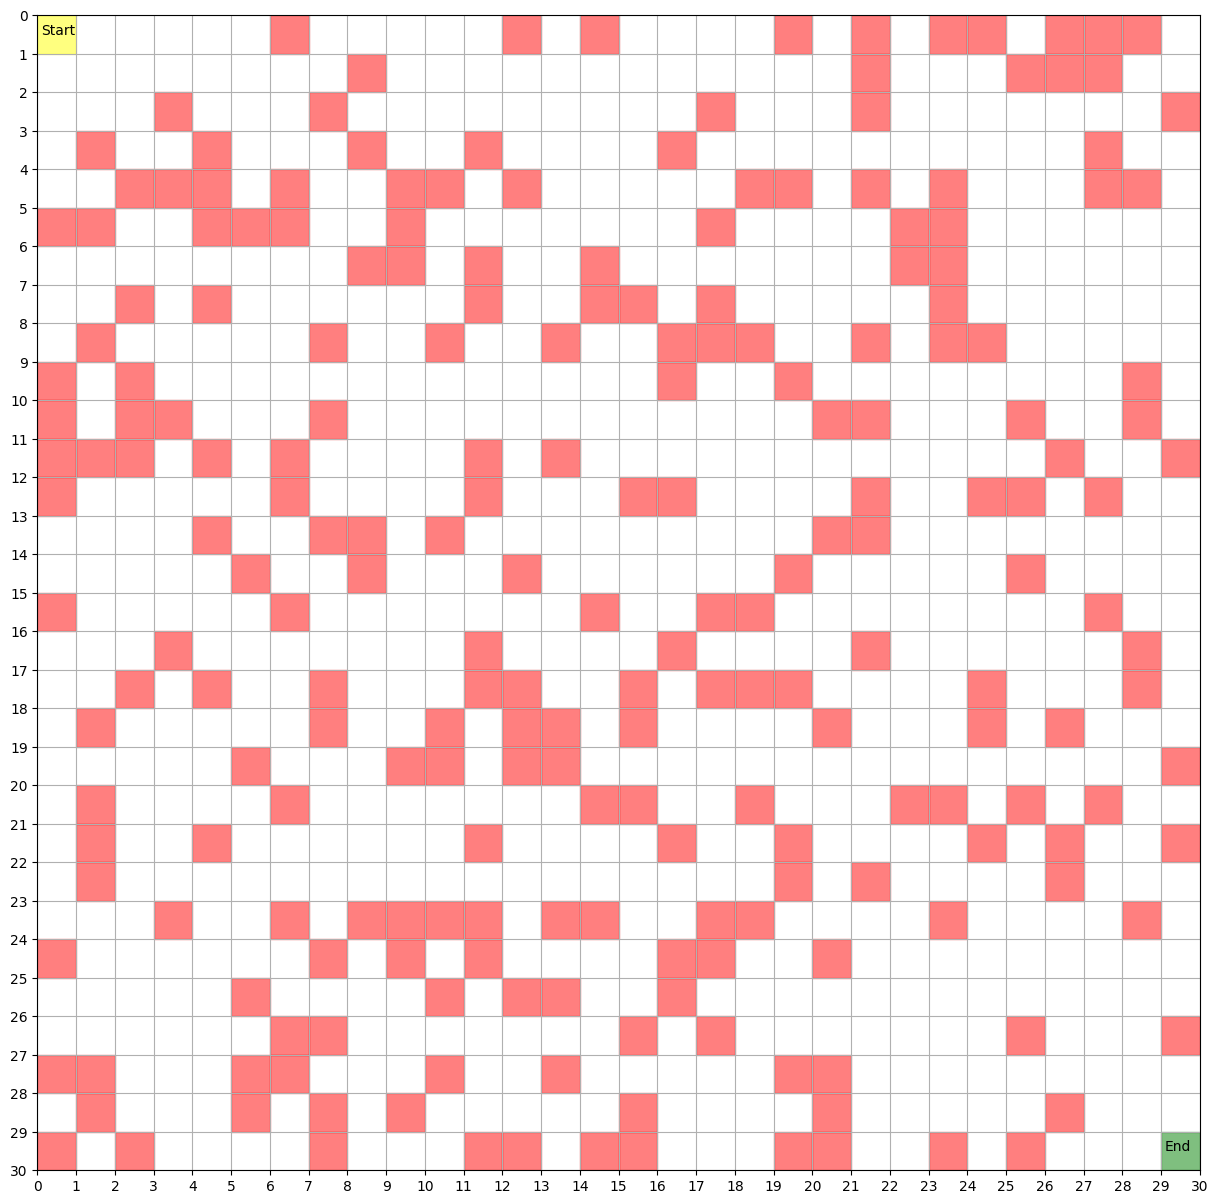

10.0% Complete
Updated epsilon 0.4
20.0% Complete
Updated epsilon 0.30000000000000004
30.0% Complete
Updated epsilon 0.20000000000000004
40.0% Complete
Updated epsilon 0.10000000000000003
50.0% Complete
60.0% Complete
70.0% Complete
80.0% Complete
90.0% Complete
******************************
Training complete
******************************


Agent starts in (0, 0)
Agent moved S
Moved to (1, 0)
Agent moved E
Moved to (1, 1)
Agent moved E
Moved to (1, 2)
Agent moved E
Moved to (1, 3)
Agent moved E
Moved to (1, 4)
Agent moved S
Moved to (2, 4)
Agent moved E
Moved to (2, 5)
Agent moved S
Moved to (3, 5)
Agent moved E
Moved to (3, 6)
Agent moved E
Moved to (3, 7)
Agent moved S
Moved to (4, 7)
Agent moved S
Moved to (5, 7)
Agent moved S
Moved to (6, 7)
Agent moved S
Moved to (7, 7)
Agent moved E
Moved to (7, 8)
Agent moved S
Moved to (8, 8)
Agent moved S
Moved to (9, 8)
Agent moved S
Moved to (10, 8)
Agent moved S
Moved to (11, 8)
Agent moved S
Moved to (12, 8)
Agent moved E
Moved to (12, 9

In [37]:
agent, gw, e, q_hat_model, q_model, sol, rewards_lst, mse_lst = main()

### Solution <a id='solution'></a>

[Top](#top)

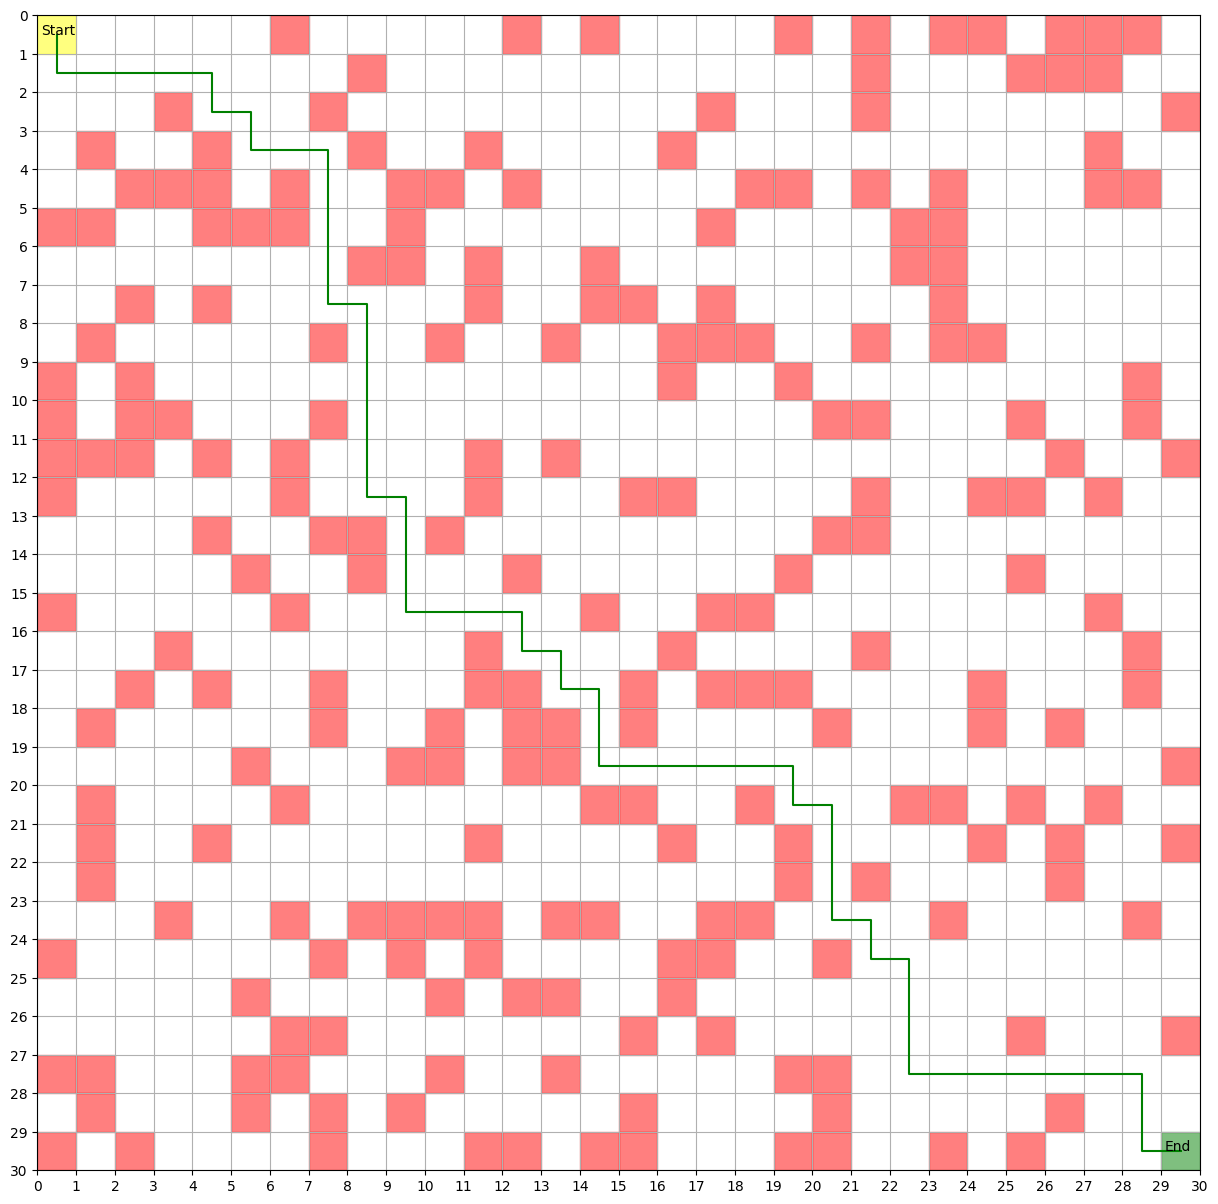

In [38]:
plot_gridworld(e, sol, solution = True)

MovieWriter ffmpeg unavailable; using Pillow instead.


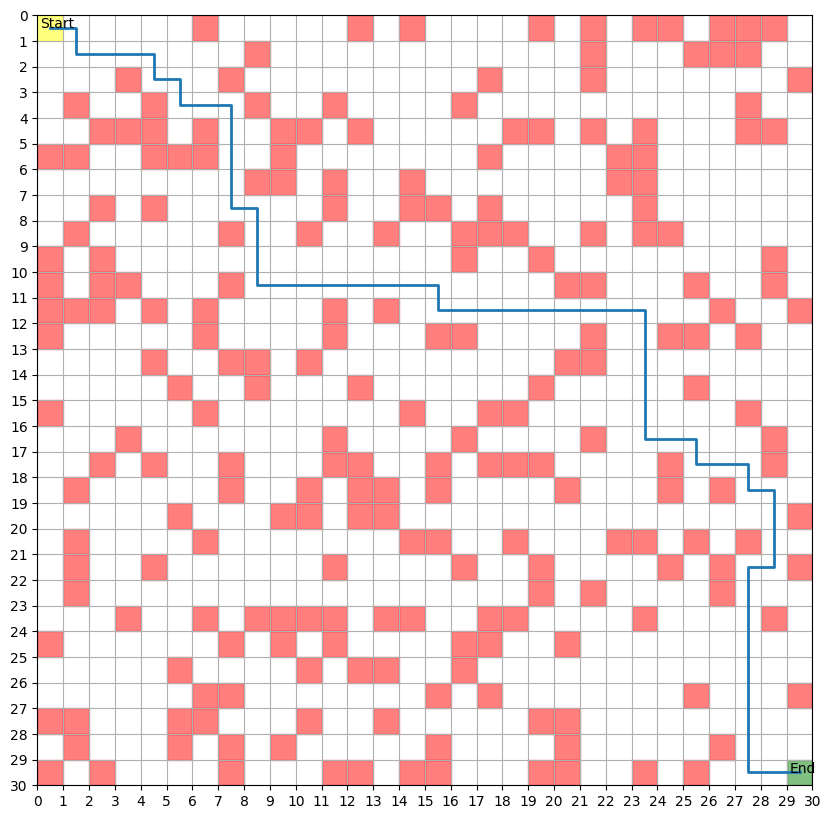

In [53]:
animate_movements(e, sol)

<img src="route_animation_state(0, 0).gif" align="center">

### MSE <a id='mse'></a>

[Top](#top)

This plot shows the MSE after every epoch during experience replay. It is very noisy but does appear to start a gradually decreasing trend around the 300,000 mark where it peaks.

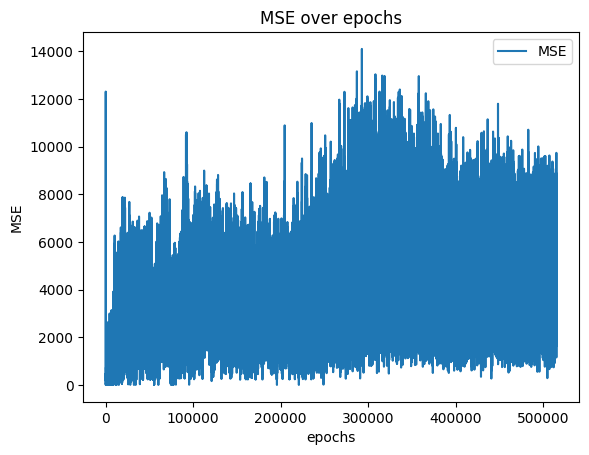

In [54]:
plot_mse(q_model.mse, 'epochs')

Plotting the MSE over episodes, so only using the MSE from the end of an episode shows a little less noise and a slowly decreasing MSE as episodes continue.

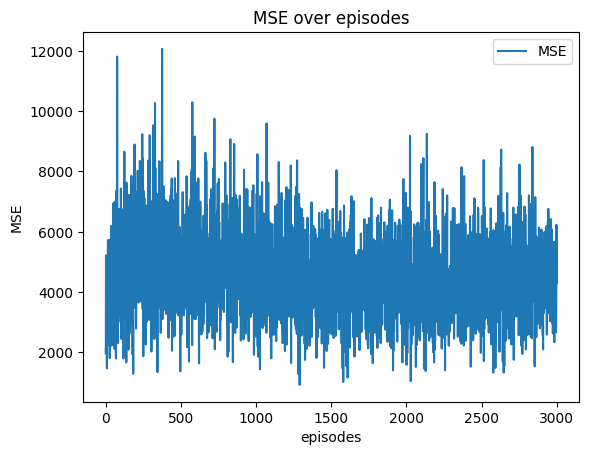

In [55]:
plot_mse(mse_lst, 'episodes')

### Selected Q value approximations <a id='selectapprox'></a>

[Top](#top)

Running inference on select cells allows us to see the estimated Q values for that state and which one should be selected to solve the maze.

Outputs in format N, S, E, W

Cell (0,0), the start position

Moving East is the best reward.

In [56]:
q_model.inference(q_model.format_input(e['world'], (0,0)))

array([[-15.17865535, -14.93197346, -14.93187011, -15.16594184]])

Cell (28,29) (One step N of goal)

We can see moving South results in the best possible reward which is the goal state.

In [57]:
q_model.inference(q_model.format_input(e['world'], (28,29)))

array([[74.11732272, 84.29301751, 79.07619598, 74.12766663]])

### Selected weight trajectories <a id='selectweights'></a>

[Top](#top)

The first 5 weights from the hidden layer to the output layer.

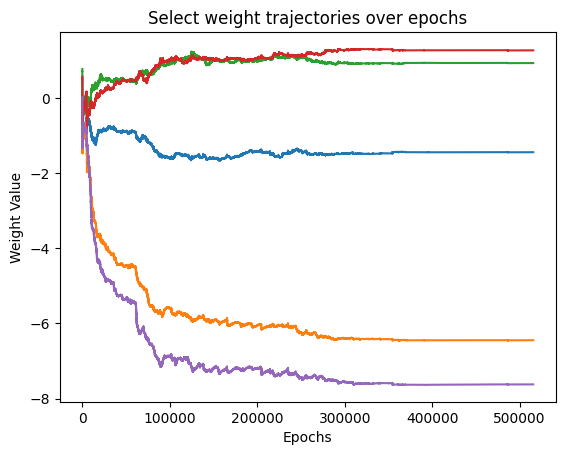

In [58]:
plot_weight_traj(q_model.selected_weights)

### Rewards over episodes <a id='rewards'></a>

[Top](#top)

Plot of reward values over iterations. It appears the agent was able to find an acceptable path by around 500 episodes and from there was able to take a path that was close to the optimal policy.

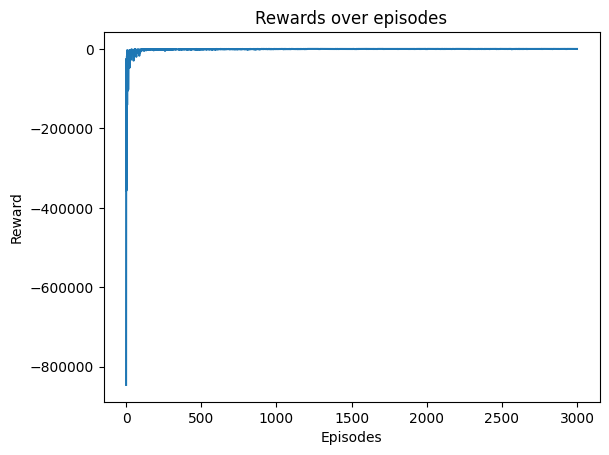

In [59]:
plot_rewards(rewards_lst)

Looking at the above plot we can see its difficult to determine what is happening aftre about 200 or so episodes, so plotting the results from episode 500 onward can shed more light on the rewards the agent earns as training progresses and the $\epsilon$ value decays.

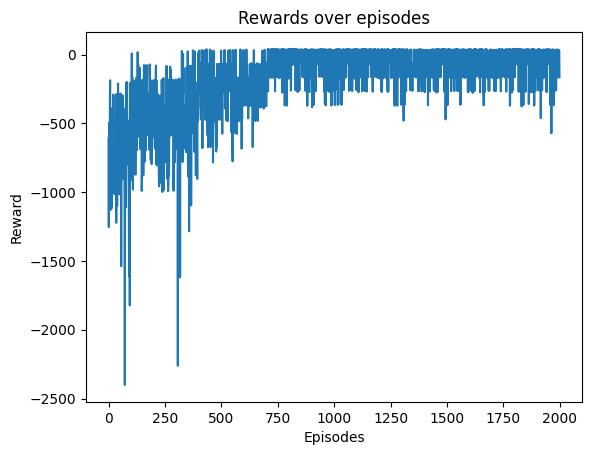

In [60]:
plot_rewards(rewards_lst[500:-500])

### Network details and discussion<a id='notes'></a>

[Top](#top)

The number of hidden layers for the network was set at one with 128 neurons using sigmoid activation. A second hidden layer was considered but was not implemented because of success with a single hidden layer. With additional layers the trainable parameters grows exponentially as increases the training time as well. 

The learning rate for both neural networks was set at 0.007. It had originally been set to 0.01 which led to poor training results, and then reduced to 0.001 which was learning slower than necessary. After some successful training runs on much smaller grid worlds the learning rate was moved from 0.001 to 0.005 and then increased until it reached 0.007 with good results. The idea behind this was to learn as quickly as possible without sacrificing time or accuracy. 

The sigmoid activation function appeared to be working fine and was kept as the activation function. The ReLu function was only experimented with early on in designing this network.

The number of episodes (M) was set to 3000 and steps per episode set to 1500. Looking at the plot of weight trajectories and rewards over episodes should give some insight into the required number of iterations. Early stopping usually resulted in the agent being unable to nagivate successfully and the number of episodes was left at 3000, likely more than required but a safe bet was to run more episodes than required. The shifting target value is likely partially to blame for this as the weights would always be moving to update themselves to match the new target output.

The agent's $\epsilon$ - greedy policy had an $\epsilon$ value of 0.5 that was decreased by 0.1 each time the training process completed 10% of training. Once this value reached 0.1 it stayed unchanged for the remainder of training. The discount factor $\gamma$ was set to 0.95. Other values such as 0.9 and 0.99 had been experimented with as well but did not seem to make a significant impact.

Two other parameters, the batch size and experience replay buffer size appeared to have a significant impact on the network as well. The experience replay buffer was initially set at 3000 along with a batch size of 64. This lead to long training times. When the replay buffer was reduced to 1000 it did not seem to have an impact on the ability to learn smaller gridworlds. As it was reduced further training continued to be successful, which is how it arrived at the final size of 500.

Reducing the batch size also sped up training and did not seem to affect the ability of the agent to learn. The batch size was started at 64, reduced to 32, and finally set at 16 with acceptable results. A benefit of a smaller batch size in this example is the network is able to update the weights quicker. The speed benefits seemed to outweight any concerns about less generalization between weight updates that come from a smaller batch size, although this could be a partial explanation of the varying MSE.

The number of steps containing experience replay was also reduced from 100, to 50, then to 25 and back to 50. Both 50 and 25 seemed to work better than 100.

### Conclusion <a id='conclusion'></a>

[Top](#top)

After completing 3000 episodes of up to 1500 steps each in just over 17 minutes, the deep Q network is able to solve the 30x30 grid world with obstacles. To achieve these results hyperparameters needed to be carefully selected. Poorer selections led to much longer training times and in many cases, the inability to solve the maze.

The cost plot showing MSE for each epoch shows a lot of noise and this is likely due to several factors, one of which is the changing target. It is likely possible to create a less noisy cost plot by fine tuning parameters such as the batch size, learning rate, $\epsilon$ value, and the number of experience replays between updating the networks to share weights again, as well as running for a longer duration of training. When the cost plot is shown only after an episode we can see a gradually decreasing cost, although this is still a noisy plot.

The plotted weight trajectories are interesting. The trajectories vary but are alike in the locations where the derivative changes significantly. They begin by very quickly changing values over the first ~100,000 or so iterations before leveling off, or at least reducing the rate of change until around ~200,000 iterations where they change a bit again before gradually leveling off for the remainder of training, appearing to converge around 400,000 epochs. The major changes to the slope of the weights is most likely due to the goal state being discovered around that 100,000 or 200,000 iteration and causing a large change to the target values and weights as the goal state gives the agent a +100 reward, the only positive reward in the entire state space. The change in weights corresponds with a rather steep increase in MSE from 200,000 to 300,000 epochs as well, and after 300,000 epochs the MSE begins to decrease.


### Looking at different starting positions

Agent starts in (13, 13)
Agent moved N
Moved to (12, 13)
Agent moved E
Moved to (12, 14)
Agent moved N
Moved to (11, 14)
Agent moved E
Moved to (11, 15)
Agent moved E
Moved to (11, 16)
Agent moved E
Moved to (11, 17)
Agent moved E
Moved to (11, 18)
Agent moved E
Moved to (11, 19)
Agent moved E
Moved to (11, 20)
Agent moved E
Moved to (11, 21)
Agent moved E
Moved to (11, 22)
Agent moved E
Moved to (11, 23)
Agent moved S
Moved to (12, 23)
Agent moved S
Moved to (13, 23)
Agent moved S
Moved to (14, 23)
Agent moved S
Moved to (15, 23)
Agent moved S
Moved to (16, 23)
Agent moved E
Moved to (16, 24)
Agent moved E
Moved to (16, 25)
Agent moved S
Moved to (17, 25)
Agent moved E
Moved to (17, 26)
Agent moved E
Moved to (17, 27)
Agent moved S
Moved to (18, 27)
Agent moved E
Moved to (18, 28)
Agent moved S
Moved to (19, 28)
Agent moved S
Moved to (20, 28)
Agent moved S
Moved to (21, 28)
Agent moved W
Moved to (21, 27)
Agent moved S
Moved to (22, 27)
Agent moved S
Moved to (23, 27)
Agent moved S
M

MovieWriter ffmpeg unavailable; using Pillow instead.


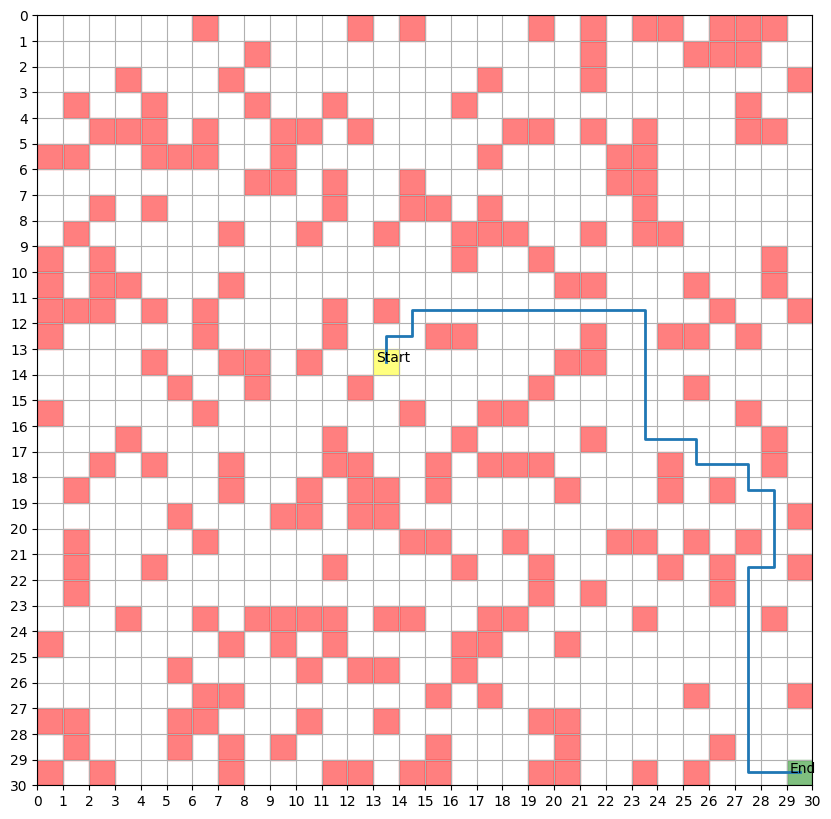

In [67]:
solution2 = follow_policy(gw, agent, e, q_model, start = (13,13))
# plot_gridworld(e, solution2, solution = True, start = (13,13))
animate_movements(e, solution2)

<img src="route_animation_state(13, 13).gif" align="center">

MovieWriter ffmpeg unavailable; using Pillow instead.


Agent starts in (25, 11)
Agent moved S
Moved to (26, 11)
Agent moved S
Moved to (27, 11)
Agent moved S
Moved to (28, 11)
Agent moved E
Moved to (28, 12)
Agent moved E
Moved to (28, 13)
Agent moved E
Moved to (28, 14)
Agent moved N
Moved to (27, 14)
Agent moved E
Moved to (27, 15)
Agent moved E
Moved to (27, 16)
Agent moved E
Moved to (27, 17)
Agent moved E
Moved to (27, 18)
Agent moved N
Moved to (26, 18)
Agent moved E
Moved to (26, 19)
Agent moved E
Moved to (26, 20)
Agent moved E
Moved to (26, 21)
Agent moved E
Moved to (26, 22)
Agent moved S
Moved to (27, 22)
Agent moved E
Moved to (27, 23)
Agent moved E
Moved to (27, 24)
Agent moved E
Moved to (27, 25)
Agent moved E
Moved to (27, 26)
Agent moved E
Moved to (27, 27)
Agent moved S
Moved to (28, 27)
Agent moved S
Moved to (29, 27)
Agent moved E
Moved to (29, 28)
Agent moved E
Moved to (29, 29)
Solved!


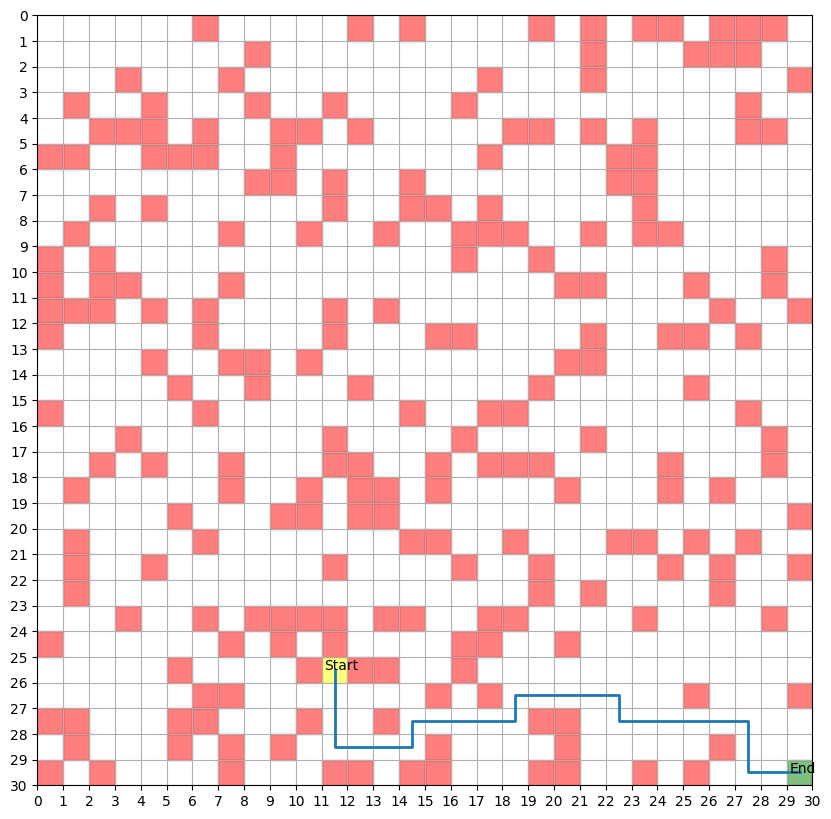

In [68]:
solution3 = follow_policy(gw, agent, e, q_model, start = (25,11))
# plot_gridworld(e, solution3, solution = True, start = (25,11))
animate_movements(e, solution3)

<img src="route_animation_state(25, 11).gif" align="center">

MovieWriter ffmpeg unavailable; using Pillow instead.


Agent starts in (28, 3)
Agent moved W
Moved to (28, 2)
Agent moved N
Moved to (27, 2)
Agent moved E
Moved to (27, 3)
Agent moved W
Moved to (27, 2)
Agent moved E
Moved to (27, 3)
Agent moved W
Moved to (27, 2)
Agent moved E
Moved to (27, 3)
Agent moved W
Moved to (27, 2)
Agent moved E
Moved to (27, 3)
Agent moved W
Moved to (27, 2)
Agent moved E
Moved to (27, 3)
Agent moved W
Moved to (27, 2)
Agent moved E
Moved to (27, 3)
Agent moved W
Moved to (27, 2)
Agent moved E
Moved to (27, 3)
Agent moved W
Moved to (27, 2)
Agent moved E
Moved to (27, 3)
Agent moved W
Moved to (27, 2)
Agent moved E
Moved to (27, 3)
Agent moved W
Moved to (27, 2)
Agent moved E
Moved to (27, 3)
Agent moved W
Moved to (27, 2)
Agent moved E
Moved to (27, 3)
Agent moved W
Moved to (27, 2)
Agent moved E
Moved to (27, 3)
Agent moved W
Moved to (27, 2)
Agent moved E
Moved to (27, 3)
Agent moved W
Moved to (27, 2)
Agent moved E
Moved to (27, 3)
Agent moved W
Moved to (27, 2)
Agent moved E
Moved to (27, 3)
Agent moved W
M

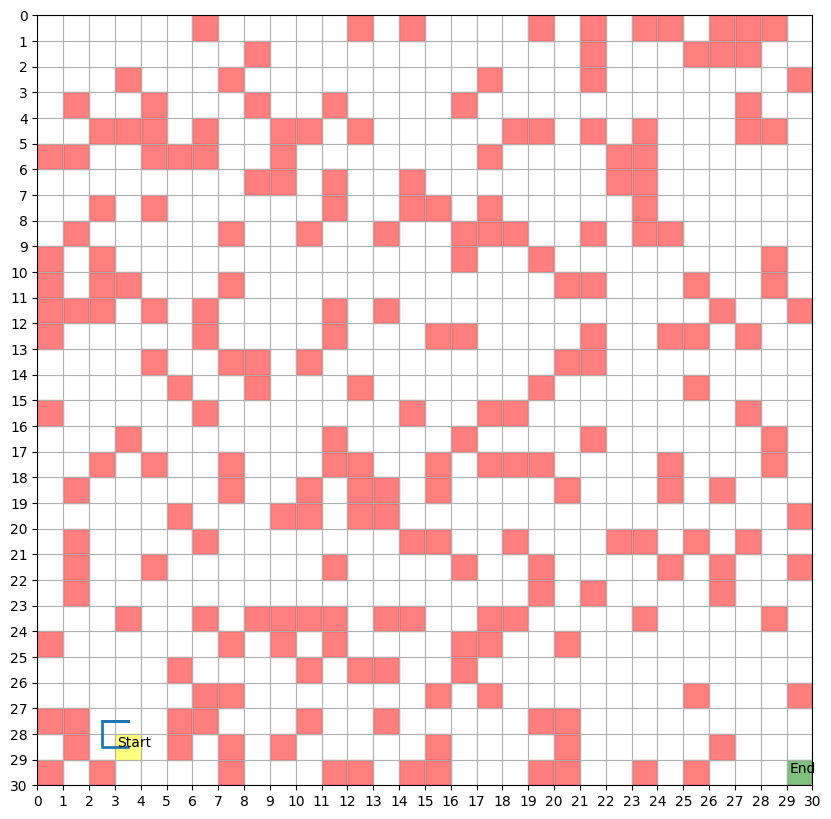

In [69]:
solution4 = follow_policy(gw, agent, e, q_model, start = (28,3))
# plot_gridworld(e, solution3, solution = True, start = (28,3))
animate_movements(e, solution4)

<img src="route_animation_state(28, 3).gif" align="center">

MovieWriter ffmpeg unavailable; using Pillow instead.


Agent starts in (14, 1)
Agent moved S
Moved to (15, 1)
Agent moved S
Moved to (16, 1)
Agent moved W
Moved to (16, 0)
Agent moved W
Moved to (16, -1)
Agent fell off gridworld, needs more training


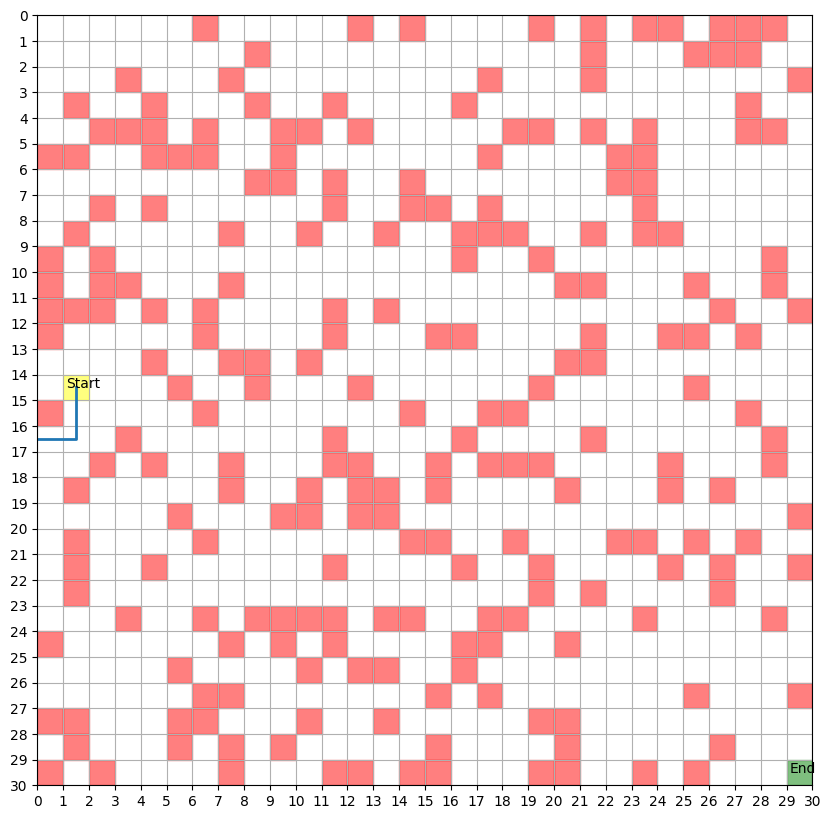

In [70]:
solution5 = follow_policy(gw, agent, e, q_model, start = (14,1))
# plot_gridworld(e, solution3, solution = True, start = (14,1))
animate_movements(e, solution5)

<img src="route_animation_state(14, 1).gif" align="center">